In [5]:
import string
import numpy as np
from torchtext import datasets
from torch.utils.data import Dataset
from torchtext.data import to_map_style_dataset
import torchtext
import torch

# Preprocessing

In [6]:
train_iter, test_iter = datasets.AG_NEWS(split=('train', 'test'))
train_ds = to_map_style_dataset(train_iter)
test_ds = to_map_style_dataset(test_iter)
train = np.array(train_ds)
test = np.array(test_ds)
dictionary = torchtext.vocab.GloVe(name="6B", dim=50).stoi

def process_phrase(phrase):
    result = []
    for word in phrase:
        if word not in dictionary.keys():
            result.append("<UNK>")
            continue
        result.append(word)
    return result + ["<PAD>"] * (50 - len(result))

def remove_punctuation(sentence):
    result = ""
    for char in sentence:
        if char not in string.punctuation + "\n": result += char
    return result

def preprocess_sentences(data):
    result = []
    for tup in data:
        phrase = remove_punctuation(tup[1])
        splitted_phrase = phrase.lower().split(" ")
        if len(tup[1].lower().split(" ")) > 50: continue
        result.append([process_phrase(splitted_phrase), int(tup[0])])
    return result

preprocessed_data_for_training = preprocess_sentences(train)
preprocessed_data_for_test = preprocess_sentences(test)

In [7]:
distinct_words = set(word for tup in preprocessed_data_for_training + preprocessed_data_for_test for word in tup[0])
vocab = {word: dictionary[word] if word in dictionary.keys() else i+1 for i, word in enumerate(distinct_words)}
vocab["<PAD>"] = 400000
vocab["<UNK>"] = 400001

class Vocabulary:
    def __init__(self, dictionary):
        self._dictionary = dictionary

    def __len__(self):
        return len(self._dictionary.keys())

    def __getitem__(self, item):
        return self._dictionary[item]

    def get(self):
        return self._dictionary

vocabulary = Vocabulary({**vocab, **dictionary})

In [8]:
len(vocabulary)

400002

In [9]:
def codify_sentence(sentence):
    return torch.tensor(np.array([vocabulary[word] for word in sentence]))

def codify_corpus(corpus):
    return [[codify_sentence(tup[0]), tup[1]] for tup in corpus]

train_data = codify_corpus(preprocessed_data_for_training)
test_data = codify_corpus(preprocessed_data_for_test)

In [10]:
class NewsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx][0]
        label = int(self.data[idx][1]) - 1
        return text, label

In [11]:
train_loader = torch.utils.data.DataLoader(NewsDataset(train_data), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(NewsDataset(test_data), batch_size=64, shuffle=True)

# Training

In [12]:
import torchtext
from torch import nn

models_dir = "models"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocabulary, embed_dim, hidden_dim, num_class, pad_idx):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(len(vocabulary), embed_dim, padding_idx=pad_idx)
        glove = torchtext.vocab.GloVe(name="6B", dim=embed_dim)
        self.embedding.weight.data.copy_(self.create_matrix(glove, embed_dim, vocabulary))
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)


    def create_matrix(self, glove, embed_dim, vocabulary):
        embedding_matrix = torch.zeros((len(vocabulary), embed_dim))
        for word, idx in vocabulary.get().items():
            embedding_matrix[idx] = glove[word]
        embedding_matrix[vocabulary["<PAD>"]] = torch.zeros(embed_dim)
        embedding_matrix[vocabulary["<UNK>"]] = torch.randn(embed_dim)
        return embedding_matrix


    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [17]:
import matplotlib.pyplot as plt

def train_network(model, train_loader, test_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc = [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch, (phrases, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            phrases, labels = phrases.to(device), labels.to(device)
            pred = model(phrases)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, test_loader))
        print("Epoch %d; Loss %f; Train Acc %f" % (epoch+1, loss, train_acc[-1]))

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for batch, (phrases, labels) in enumerate(data_loader):
        phrases, labels = phrases.to(device), labels.to(device)
        output = model(phrases)
        correct += (output.argmax(1) == labels).sum().item()
        total += labels.shape[0]
        if batch == 30: break
    return correct / total

Epoch 1; Loss 0.573542; Train Acc 0.821069
Epoch 2; Loss 0.572803; Train Acc 0.865927
Epoch 3; Loss 0.296820; Train Acc 0.893145
Epoch 4; Loss 0.175995; Train Acc 0.891633
Epoch 5; Loss 0.362217; Train Acc 0.899698
Epoch 6; Loss 0.261613; Train Acc 0.902722
Epoch 7; Loss 0.195224; Train Acc 0.909274
Epoch 8; Loss 0.297482; Train Acc 0.906250


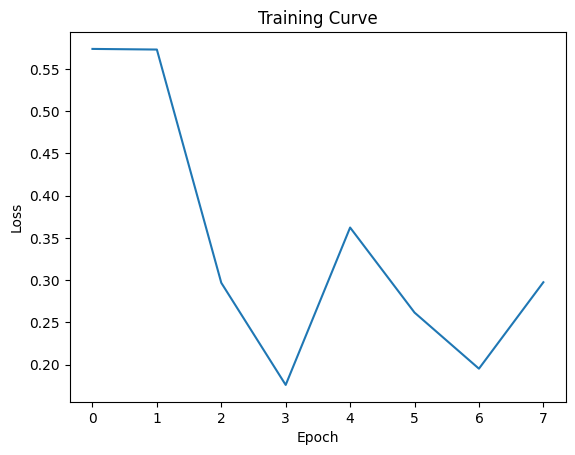

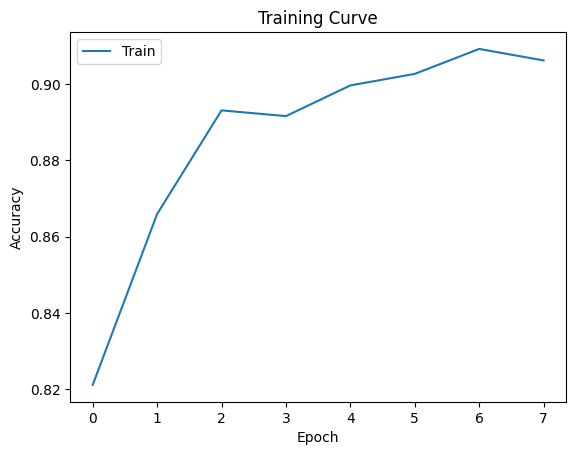

0.9122983870967742

In [18]:
model = LSTMTextClassificationModel(vocabulary, 50, 64, 4, 400000)
model.to(device)

train_network(model, train_loader, test_loader, num_epochs=8, learning_rate=1e-4)
get_accuracy(model, test_loader)

In [19]:
torch.save(model, models_dir + "/model50.pt")

Epoch 1; Loss 0.783847; Train Acc 0.746472
Epoch 2; Loss 0.408192; Train Acc 0.884073
Epoch 3; Loss 0.101849; Train Acc 0.892641
Epoch 4; Loss 0.158770; Train Acc 0.901714
Epoch 5; Loss 0.233033; Train Acc 0.907258
Epoch 6; Loss 0.343089; Train Acc 0.906754
Epoch 7; Loss 0.089729; Train Acc 0.912298
Epoch 8; Loss 0.225238; Train Acc 0.898690


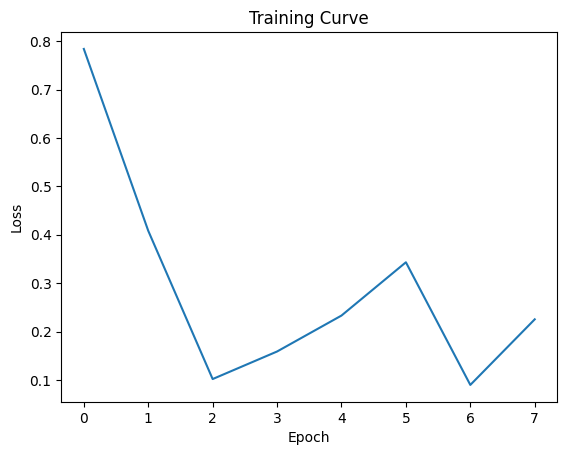

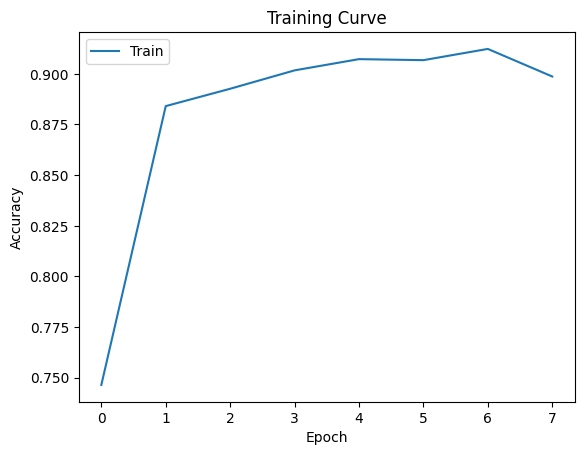

0.921875

In [184]:
model_1 = LSTMTextClassificationModel(vocabulary, 100, 64, 4, 400000)
model_1.to(device)

train_network(model_1, train_loader, test_loader, num_epochs=8, learning_rate=1e-4)
get_accuracy(model_1, test_loader)

In [195]:
torch.save(model_1, models_dir + "/model100.pt")

100%|█████████▉| 399999/400000 [00:34<00:00, 11443.25it/s]


Epoch 1; Loss 0.210429; Train Acc 0.872984
Epoch 2; Loss 0.278948; Train Acc 0.896169
Epoch 3; Loss 0.292373; Train Acc 0.899194
Epoch 4; Loss 0.061769; Train Acc 0.910282
Epoch 5; Loss 0.050248; Train Acc 0.909778
Epoch 6; Loss 0.083924; Train Acc 0.918347
Epoch 7; Loss 0.128457; Train Acc 0.908266
Epoch 8; Loss 0.224764; Train Acc 0.919859


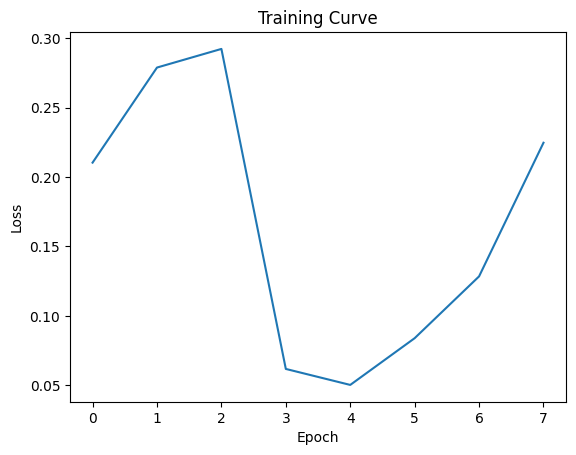

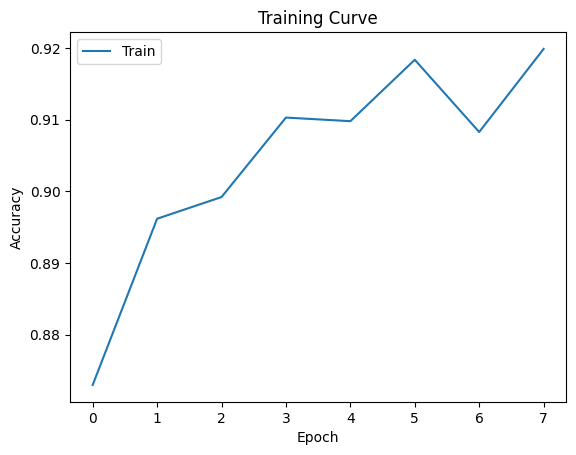

0.921875

In [236]:
model_2 = LSTMTextClassificationModel(vocabulary, 200, 64, 4, 400000)
model_2.to(device)

train_network(model_2, train_loader, test_loader, num_epochs=8, learning_rate=1e-4)
get_accuracy(model_2, test_loader)

In [237]:
torch.save(model_2, models_dir + "/model200.pt")

Epoch 1; Loss 0.432788; Train Acc 0.829637
Epoch 2; Loss 0.477916; Train Acc 0.881048
Epoch 3; Loss 0.158039; Train Acc 0.904234
Epoch 4; Loss 0.284405; Train Acc 0.912802
Epoch 5; Loss 0.163110; Train Acc 0.914819
Epoch 6; Loss 0.114525; Train Acc 0.910786
Epoch 7; Loss 0.069228; Train Acc 0.914819
Epoch 8; Loss 0.101486; Train Acc 0.909778


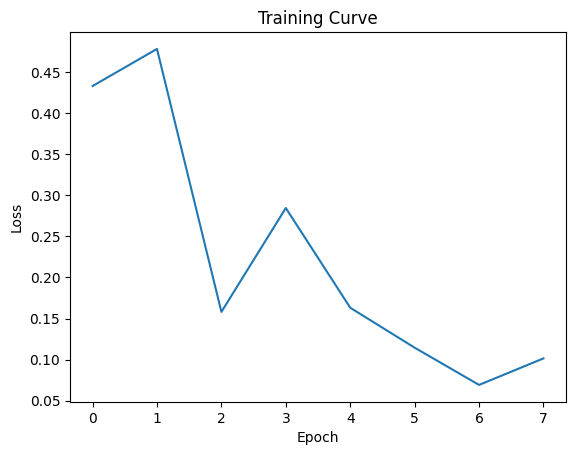

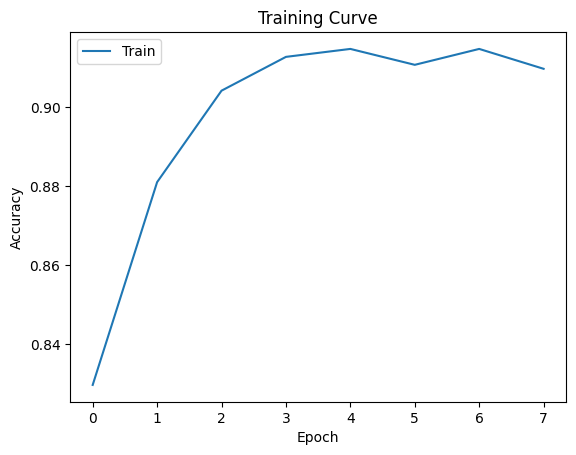

0.9198588709677419

In [21]:
model_3 = LSTMTextClassificationModel(vocabulary, 300, 64, 4, 400000)
model_3.to(device)

train_network(model_3, train_loader, test_loader, num_epochs=8, learning_rate=1e-4)
get_accuracy(model_3, test_loader)

In [23]:
torch.save(model_3, models_dir + "/model300.pt")